Filtered with Gaussian
Original image dimensions: (27499, 26788, 3)
Water mask dimensions: (27499, 26788)


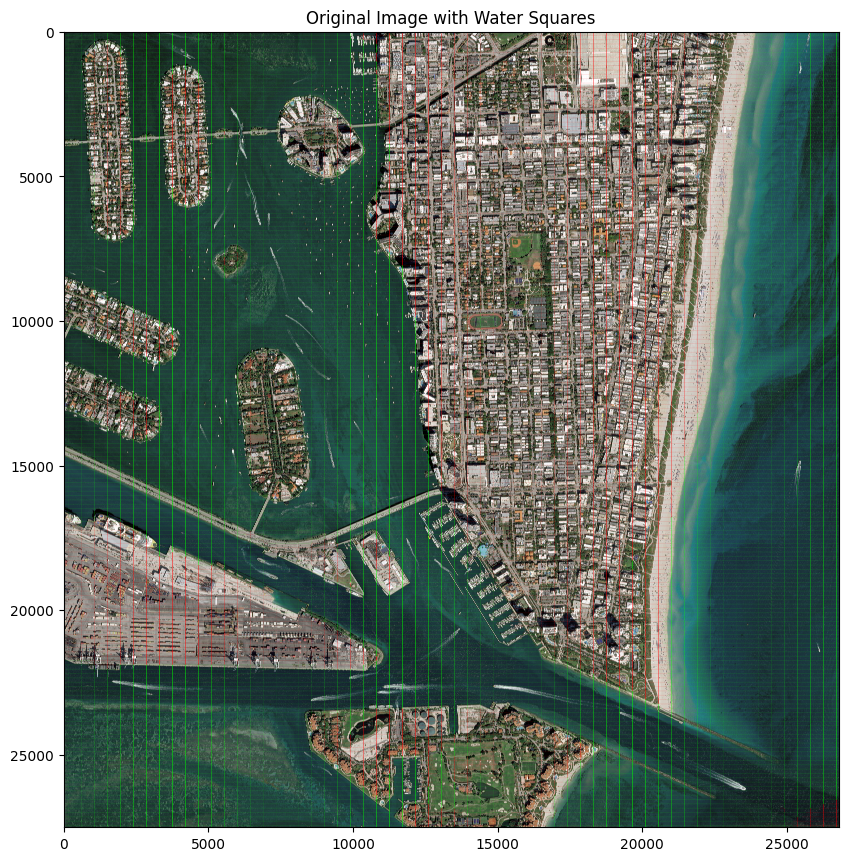

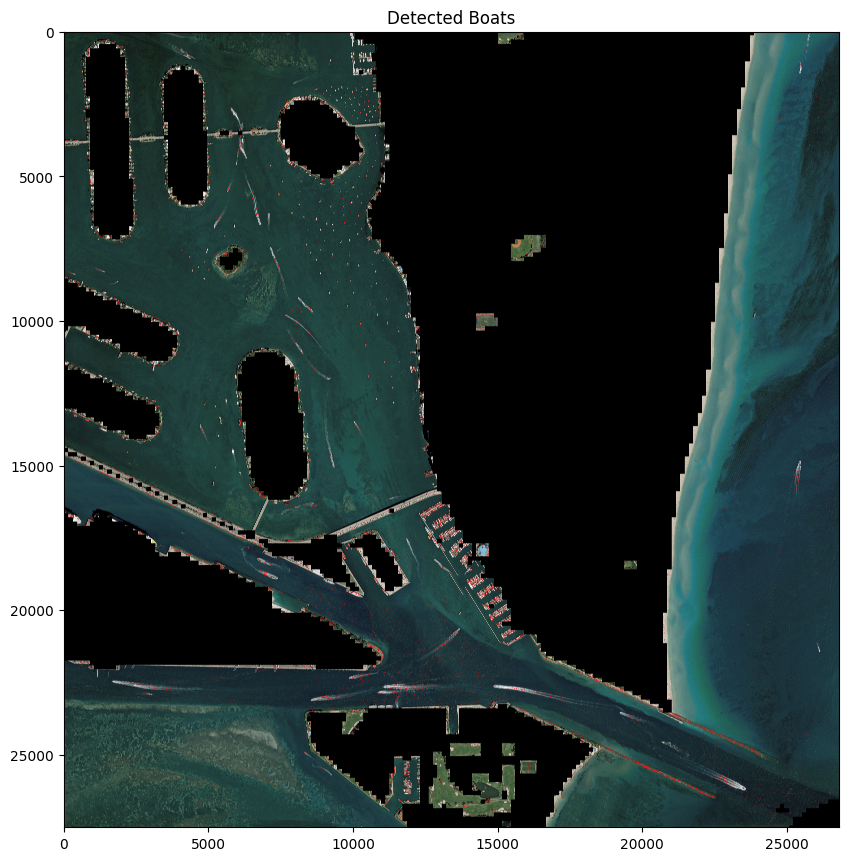

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib

# Function to apply Gaussian filter
def apply_gaussian_filter(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Function to load, resize and preprocess images
def load_and_preprocess_image(image_path, scale_percent, filter_type=False, kernel_size=5):
    image = cv2.imread(image_path)
    new_width = int(image.shape[1] * scale_percent / 100)
    new_height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (new_width, new_height))
    
    if filter_type:
        resized_image = apply_gaussian_filter(resized_image, kernel_size)
        print("Filtered with Gaussian")
    
    return resized_image

# Function to draw grid lines on the image
def draw_grid_lines(image, square_size, line_thickness=2, color=(0, 0, 255)):
    img_height, img_width = image.shape[:2]
    grid_image = image.copy()
    
    # Draw horizontal lines
    for y in range(0, img_height, square_size):
        cv2.line(grid_image, (0, y), (img_width, y), color, line_thickness)
    
    # Draw vertical lines
    for x in range(0, img_width, square_size):
        cv2.line(grid_image, (x, 0), (x, img_height), color, line_thickness)
    
    return grid_image

# Load the original image
original_image_path = "../satellite-images/Miami.jpg"
filter_true = True  # Apply Gaussian filter
scale_percent = 100  # Full scale
kernel_size = 5  # Kernel size for Gaussian filter
original_image_rescaled = load_and_preprocess_image(original_image_path, scale_percent, filter_true, kernel_size)

# Load the water mask from the .pkl file
water_mask_pkl_path = '../dilated_image_water_mask.pkl'
water_mask_binary = joblib.load(water_mask_pkl_path)

# Resize the water mask to match the original image dimensions
water_mask_image_rescaled = cv2.resize(water_mask_binary, (original_image_rescaled.shape[1], original_image_rescaled.shape[0]), interpolation=cv2.INTER_NEAREST)

# Verify dimensions
print(f"Original image dimensions: {original_image_rescaled.shape}")
print(f"Water mask dimensions: {water_mask_image_rescaled.shape}")

# Define square size
square_size = 150  # Example size, you can adjust it as needed

# Draw grid lines on the original image and water mask for visual segmentation
original_image_with_grid = draw_grid_lines(original_image_rescaled, square_size)
water_mask_with_grid = draw_grid_lines(water_mask_image_rescaled, square_size)

# Create a list to store water-containing segments
water_segments = []

# Collect segments that contain water and replace non-water segments with black squares
for y in range(0, original_image_rescaled.shape[0], square_size):
    for x in range(0, original_image_rescaled.shape[1], square_size):
        water_segment = water_mask_image_rescaled[y:y+square_size, x:x+square_size]
        if np.any(water_segment == 1):  # Check if the segment contains water
            segment = original_image_rescaled[y:y+square_size, x:x+square_size]
            water_segments.append((segment, (x, y)))
        else:
            original_image_rescaled[y:y+square_size, x:x+square_size] = 0

# Apply template matching and highlight matches
overlay_image = original_image_rescaled.copy()
# kernel_size = 15
for segment, (x, y) in water_segments:
    # Apply Gaussian filter
    segment = apply_gaussian_filter(segment, kernel_size)
    edges = cv2.Canny(segment, 50, 200)
    # edges = cv2.Canny(segment, 10, 50)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Filter contours based on size and shape
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if 75 < area < 4000:  # Example size filter, adjust as needed
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
            if len(approx) > 4:  # Example shape filter, adjust as needed
                filtered_contours.append(contour)
    # Highlight detected contours on the segment
    cv2.drawContours(overlay_image[y:y+square_size, x:x+square_size], filtered_contours, -1, (0, 0, 255), 2)
    cv2.rectangle(original_image_with_grid, (x, y), (x + square_size, y + square_size), (0, 255, 0), 2)

# Save the images
# cv2.imwrite("../original_image_100p_150sq.png", original_image_with_grid)
# cv2.imwrite("../overlay_image_100p_150sq_75-4000_gauss_1len.png", overlay_image)

# cv2.imwrite("../original_image_10p_25sq.png", original_image_with_grid)
# cv2.imwrite("../overlay_image_10p_25sq_5-4000_gauss.png", overlay_image)

# Display the images
plt.figure(figsize=(10, 20))
plt.title('Original Image with Water Squares')
plt.imshow(cv2.cvtColor(original_image_with_grid, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(10, 20))
plt.title('Detected Boats')
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))

plt.show()